In [2]:
import zipfile
zip_path="/content/drive/MyDrive/Colab Notebooks/train.csv.zip"
output_path="/content/drive/MyDrive/Colab Notebooks/da"
with zipfile.ZipFile(zip_path,"r") as zip:
  zip.extractall(output_path)

In [3]:
zip_path="/content/drive/MyDrive/Colab Notebooks/test.csv.zip"
with zipfile.ZipFile(zip_path,"r") as zip:
  zip.extractall(output_path)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df1=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/da/train.csv")
df2=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/da/test.csv")
df=pd.concat([df1,df2],ignore_index=True)
df.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,...,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,no stress
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,...,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,interruption
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,...,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,interruption
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,...,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,no stress
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,...,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,no stress


Since our final dataset was divided into training and testing data specifically so to ML models for prediction.As our scope is limited to only finding relationships we will be combining both

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410322 entries, 0 to 410321
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MEAN_RR            410322 non-null  float64
 1   MEDIAN_RR          410322 non-null  float64
 2   SDRR               410322 non-null  float64
 3   RMSSD              410322 non-null  float64
 4   SDSD               410322 non-null  float64
 5   SDRR_RMSSD         410322 non-null  float64
 6   HR                 410322 non-null  float64
 7   pNN25              410322 non-null  float64
 8   pNN50              410322 non-null  float64
 9   SD1                410322 non-null  float64
 10  SD2                410322 non-null  float64
 11  KURT               410322 non-null  float64
 12  SKEW               410322 non-null  float64
 13  MEAN_REL_RR        410322 non-null  float64
 14  MEDIAN_REL_RR      410322 non-null  float64
 15  SDRR_REL_RR        410322 non-null  float64
 16  RM

With this description it is clear that the data has no missing values

In [6]:
df.duplicated().sum()

np.int64(0)

Data also has no duplicates to be handeled

In [7]:
df.drop("datasetId",axis=1,inplace=True)

In [8]:
df.interpolate(methold="Linear",inplace=True)

/tmp/ipython-input-3252832531.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(methold="Linear",inplace=True)


/tmp/ipython-input-3052712065.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


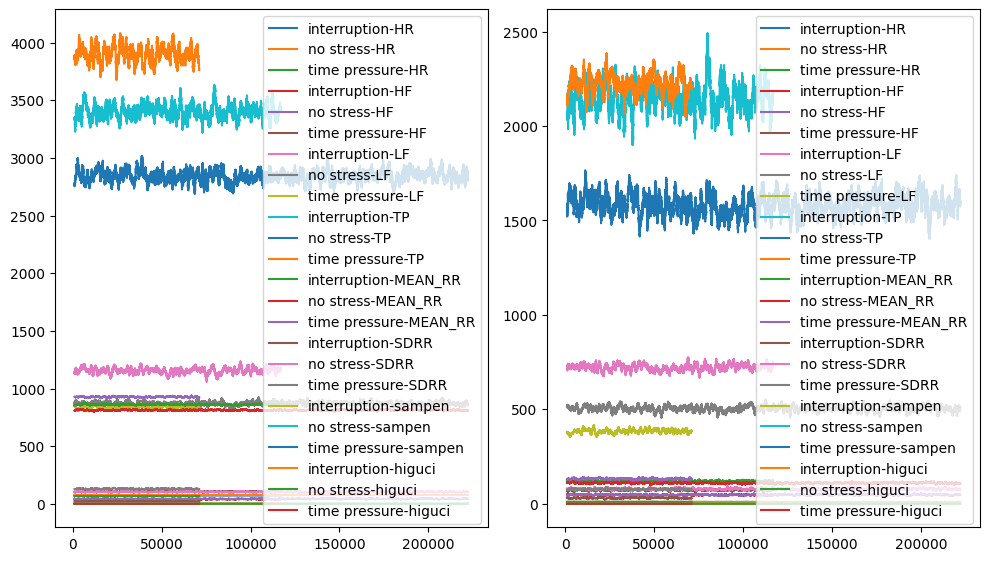

In [9]:
metrics=["HR","HF","LF","TP","MEAN_RR","SDRR","sampen","higuci"]
fig,ax=plt.subplots(1,2,figsize=(10,6))
for metric in metrics:
  for cond,group in df.groupby("condition"):
    group[f"{metric}_mean"]=group[metric].reset_index(drop=True).rolling(window=1000).mean()
    group[f"{metric}_std"]=group[metric].reset_index(drop=True).rolling(window=1000).std()
    ax[0].plot(group[f"{metric}_mean"],label=f"{cond}-{metric}")
    ax[1].plot(group[f"{metric}_std"],label=f"{cond}-{metric}")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()


rolling mean and std are not slowly deviating away as in they always go up and come down or stay stagant this is the sign of no drift in case of gradual changes as if there were sensor drifts we would see the plots having a uptick or a downtick , this tells us there is no gradual shifts in sensor's measurments over each group on a window of 1000 samples hence we can resort to normalizing and finding outliers and can use z-score filtering to find unusual data

In [10]:
metrics=["HR","HF","LF","TP","MEAN_RR","SDRR","sampen","higuci"]
df_z=df.groupby("condition")[metrics].transform(lambda x: (x-np.mean(x))/np.std(x))
df_z["condition"]=df["condition"]
df_z

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,HR,HF,LF,TP,MEAN_RR,SDRR,sampen,higuci,condition
0,-0.744534,-0.587178,0.272648,0.532889,0.655842,0.473733,0.440266,-0.373886,no stress
1,-0.837927,-0.828014,-0.643940,-0.183724,0.648035,-0.347406,0.488193,-1.647409,interruption
2,-0.514699,-0.577179,0.197180,-0.332752,0.305134,-0.303341,0.176134,-0.223853,interruption
3,-0.815495,-0.531366,0.266173,0.373674,0.624943,-0.173806,0.594234,-0.100115,no stress
4,-0.223852,0.098969,1.090028,-0.139907,-0.030596,-0.527048,0.764936,1.081335,no stress
...,...,...,...,...,...,...,...,...,...
410317,-1.328150,-0.767551,0.342280,0.540642,1.443696,-0.216627,0.769038,-1.213838,time pressure
410318,0.424219,1.665146,0.131304,2.384981,-0.045712,2.638476,-3.331313,-0.564885,interruption
410319,1.388657,3.624546,2.060692,2.040510,-1.123304,0.382147,0.193855,0.494317,no stress
410320,0.264174,-0.035742,-0.610613,-0.950295,-0.468670,-0.552303,0.646260,0.826788,no stress


Text(0.5, 0, 'conditions')

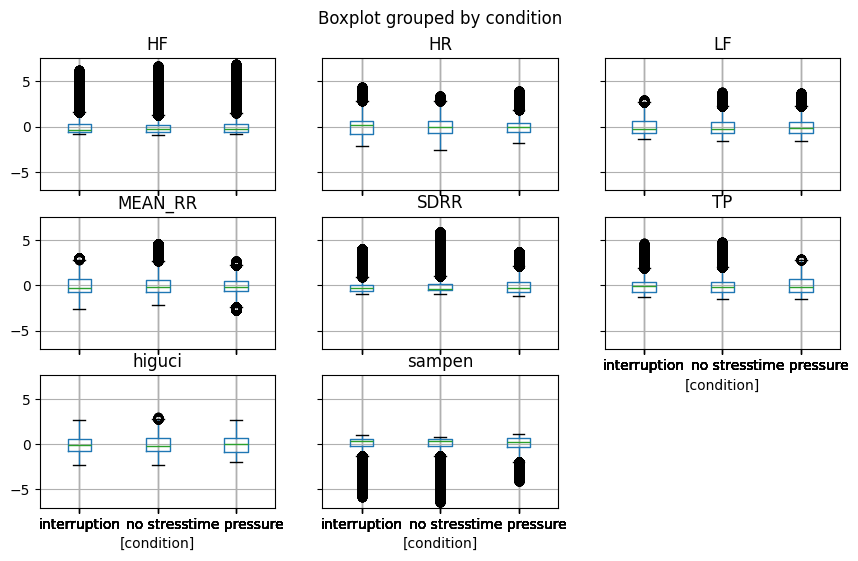

In [11]:
df_z.boxplot(by="condition",figsize=(10,6))
plt.xlabel("conditions")

our boxplot tells how in most metrics the data is heavily left skewed so apply a high threshold of 3 wouldnt work either as in z-score normalization we assume a normal distribution so let us make this a normal distribution through log transform.

In [12]:
for metric in metrics:
  df[metric]=np.log1p(df[metric])
df[metrics]

,HR,HF,LF,TP,MEAN_RR,SDRR,sampen,higuci
0,4.255612,2.804729,6.917953,8.212749,6.786895,4.955635,1.144144,0.771720
1,4.179959,1.134148,6.538304,8.008860,6.846332,4.410587,1.155150,0.734630
2,4.226105,2.692580,7.169521,7.896136,6.801490,4.448484,1.142741,0.777633
3,4.245771,2.953968,6.914713,8.141924,6.783051,4.514923,1.156359,0.779182
4,4.325003,3.896215,7.260369,7.871759,6.697806,4.155224,1.169729,0.810758
...,...,...,...,...,...,...,...,...
410317,4.011582,0.298261,6.877863,8.537333,7.020554,4.744546,1.157969,0.733774
410318,4.349206,4.779242,7.132175,9.051767,6.753428,5.696299,0.991519,0.767498
410319,4.513647,5.380823,7.556259,8.711979,6.537255,4.903909,1.124280,0.795193
410320,4.385941,3.756472,6.335881,7.199515,6.636500,4.123785,1.160453,0.804038


In [13]:
df_z=df.groupby("condition")[metrics].transform(lambda x: (x-np.mean(x))/np.std(x))
df_z["condition"]=df["condition"]
df_z

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,HR,HF,LF,TP,MEAN_RR,SDRR,sampen,higuci,condition
0,-0.718000,-0.526605,0.532768,0.724799,0.714557,0.890808,0.417117,-0.364153,no stress
1,-0.816853,-1.757888,-0.490578,0.095938,0.706194,-0.224883,0.480733,-1.680852,interruption
2,-0.464523,-0.397410,0.487016,-0.087176,0.375871,-0.150183,0.187564,-0.210847,interruption
3,-0.796531,-0.376851,0.527109,0.599702,0.685237,0.055578,0.544775,-0.087236,no stress
4,-0.164272,0.568649,1.130885,0.122515,0.035072,-0.626118,0.684507,1.084647,no stress
...,...,...,...,...,...,...,...,...,...
410317,-1.521726,-2.062708,0.549801,0.712905,1.333867,0.022122,0.749014,-1.224037,time pressure
410318,0.475375,1.424203,0.429175,1.790077,0.021829,2.309404,-3.385106,-0.557291,interruption
410319,1.341079,2.058382,1.647729,1.606579,-1.189454,0.792777,0.209513,0.507008,no stress
410320,0.322007,0.428423,-0.483964,-1.064859,-0.432512,-0.685701,0.587561,0.835270,no stress


array([[<Axes: title={'center': 'HF'}, xlabel='[condition]'>,
        <Axes: title={'center': 'HR'}, xlabel='[condition]'>,
        <Axes: title={'center': 'LF'}, xlabel='[condition]'>],
       [<Axes: title={'center': 'MEAN_RR'}, xlabel='[condition]'>,
        <Axes: title={'center': 'SDRR'}, xlabel='[condition]'>,
        <Axes: title={'center': 'TP'}, xlabel='[condition]'>],
       [<Axes: title={'center': 'higuci'}, xlabel='[condition]'>,
        <Axes: title={'center': 'sampen'}, xlabel='[condition]'>,
        <Axes: >]], dtype=object)

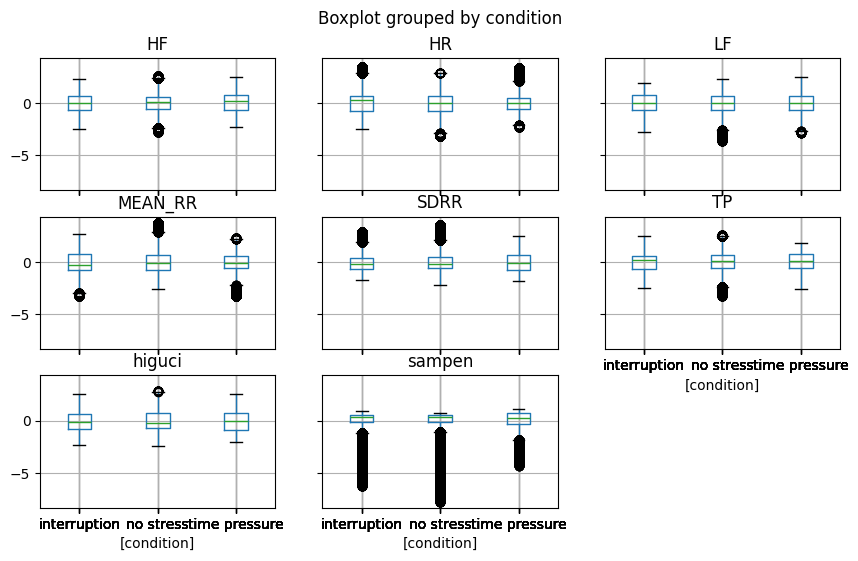

In [14]:
df_z.boxplot(by="condition",figsize=(10,6))

In [15]:
threshold=3
drifts=(df_z[metrics].abs()>threshold)
drifts_count=drifts.groupby(df["condition"]).sum()
print(drifts_count)
print((df_z["HR"]<(-threshold)).groupby(df["condition"]).sum())
print((df_z[["MEAN_RR","SDRR"]]>threshold).groupby(df["condition"]).sum())
print((df_z["sampen"]>threshold).groupby(df["condition"]).sum())

                 HR  HF   LF   TP  MEAN_RR  SDRR  sampen  higuci
condition                                                       
interruption    778   0    0    0      482     0    2774       0
no stress       330   0  986  743     1384  1953    6362       0
time pressure  2283   0    0    0     2073     0    2232       0
condition
interruption       0
no stress        330
time pressure      0
Name: HR, dtype: int64
               MEAN_RR  SDRR
condition                   
interruption         0     0
no stress         1384  1953
time pressure        0     0
condition
interruption     0
no stress        0
time pressure    0
Name: sampen, dtype: int64


The z-score normalization was done and threshold was set to 3 so that most extreme devations of 3*std can be checked in each metric per condition but this might not be conclusive enough to remove them

Here first data was made into a normal distribution to make z-score values more meaningful and then post z-score normalization we found out the box plot where in most of left skewed plots were now normalized so the threshold of 3 was set to find extreme outliers here firstly HF has no outliers perfectly normal , LF as TP have extremity in case of no stress condition noramlly LF and TP must not be in extremes for such a normal condition hence we treat it as drift .
Now one simple thing about heart rates are that for high stress conditions heart rate is high or very high and for no stress it is balanced so its clear it will not hit extreme low rates in any condition hence we have the 2nd table with heart rates lesser than -3*std.
Opposite is the case of RR intervals which are inverse to HR they must very low a extreme high value indicates drift.

In [16]:
drift_lf_tp=(df_z[["LF","TP"]].abs()>threshold)
drift_hr=(df_z["HR"]<(-threshold))
drift_rr=(df_z[["MEAN_RR","SDRR"]]>threshold)
drift_clean=pd.concat([drift_lf_tp,drift_hr,drift_rr],axis=1)
df_z_clean=df_z[~drift_clean.any(axis=1)]
df_z_clean

,HR,HF,LF,TP,MEAN_RR,SDRR,sampen,higuci,condition
0,-0.718000,-0.526605,0.532768,0.724799,0.714557,0.890808,0.417117,-0.364153,no stress
1,-0.816853,-1.757888,-0.490578,0.095938,0.706194,-0.224883,0.480733,-1.680852,interruption
2,-0.464523,-0.397410,0.487016,-0.087176,0.375871,-0.150183,0.187564,-0.210847,interruption
3,-0.796531,-0.376851,0.527109,0.599702,0.685237,0.055578,0.544775,-0.087236,no stress
4,-0.164272,0.568649,1.130885,0.122515,0.035072,-0.626118,0.684507,1.084647,no stress
...,...,...,...,...,...,...,...,...,...
410317,-1.521726,-2.062708,0.549801,0.712905,1.333867,0.022122,0.749014,-1.224037,time pressure
410318,0.475375,1.424203,0.429175,1.790077,0.021829,2.309404,-3.385106,-0.557291,interruption
410319,1.341079,2.058382,1.647729,1.606579,-1.189454,0.792777,0.209513,0.507008,no stress
410320,0.322007,0.428423,-0.483964,-1.064859,-0.432512,-0.685701,0.587561,0.835270,no stress


In [17]:
df_z_clean[metrics].describe()

,HR,HF,LF,TP,MEAN_RR,SDRR,sampen,higuci
count,407089.000000,407089.000000,407089.000000,407089.000000,407089.000000,407089.000000,407089.000000,407089.000000
mean,0.007582,0.008860,0.019774,-0.000335,-0.015482,-0.016604,0.021787,0.008770
std,0.992733,0.997131,0.976607,0.991857,0.977955,0.969971,0.947672,0.992507
min,-2.594137,-2.529875,-2.896203,-2.999990,-3.305152,-2.167675,-7.768936,-2.367240
25%,-0.690778,-0.594785,-0.646045,-0.637060,-0.731097,-0.646131,-0.135618,-0.728061
50%,0.085876,0.063723,-0.010993,0.108782,-0.138988,-0.211311,0.356709,-0.123364
75%,0.675798,0.661138,0.743815,0.633775,0.681542,0.454018,0.566314,0.681763
max,3.480468,2.580585,2.462887,2.561060,2.999999,2.999488,1.102555,2.874537


Now we will look towards finding trends and exploration of data and finding out relationships b/w variables
1.Sampen is an entropy measure that deals with how random is the pattern in a ecg or rr interval is so its measure of randomness and we really want to see per a particular value of hr how random/erratic is the signal , this will help us understand the theory of wherther high hr corresponds to the quicker reptition of similar patterns.
We will make use of scatter plot as both of these variables are continous

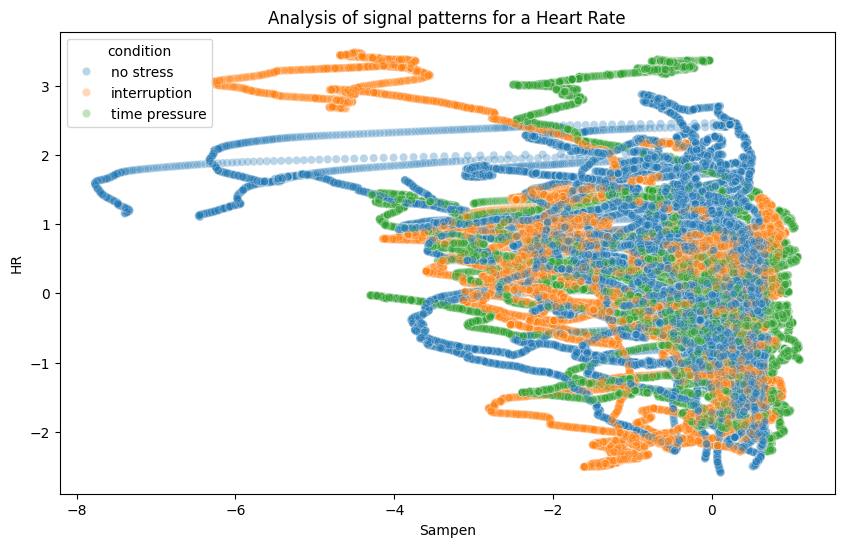

In [18]:
plt.figure(figsize=(10,6))
df_z_clean.sample(1000,random_state=42)
sns.scatterplot(data=df_z_clean,x="sampen",y="HR",hue="condition",alpha=0.3)
plt.title("Analysis of signal patterns for a Heart Rate")
plt.xlabel("Sampen")
plt.ylabel("HR")
plt.show()

The plot might look cluttered but this plot does give an answer to the question raised previously that is with a higher heart rate our sample entropy reduces as we can see it becomes more and more scatterd and goes away from 0.
Now using condition as hue we can see a strange behaviour the no stress conditions are tending to expand more on the -ve sample entropy meaning less randomness and they are also somehow having higher hr (as we aldready established hr is inversely proportional to sampen) but this seems contradictory so we will use a bar graph to see the trend in hr vs condition

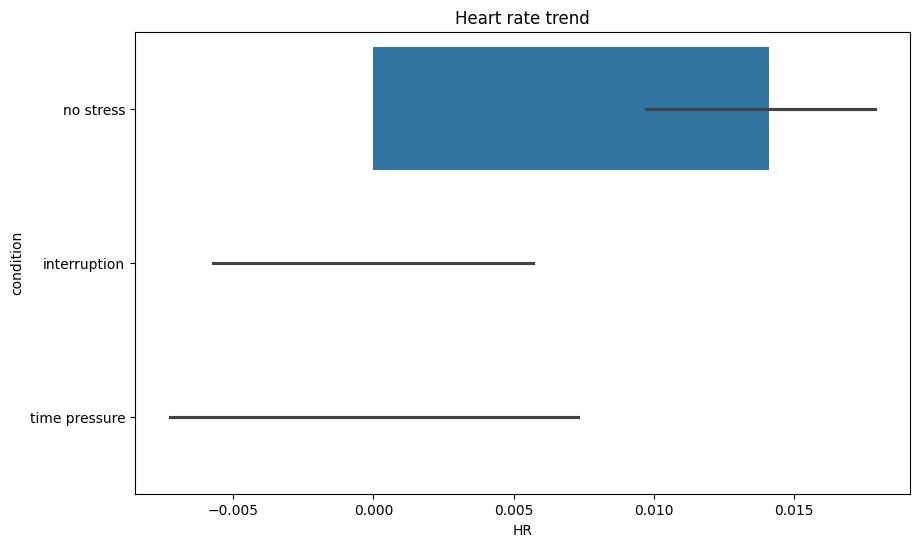

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_z_clean,x="HR",y="condition")
plt.title("Heart rate trend")
plt.xlabel("HR")
plt.ylabel("condition")
plt.show()

we can clearly see higher heart rate values correspond to no stress while in comparison of low heart rate is for more stressful situation but that is just the problem created by z-score normalized values as in z-score normalized values every value differs from mean=0 by +-1 hence we see this odd sort of trend while in reality if see the mean hr vs condition in original data it is negligble i.e.,
for no stress->slightly high hr mean (thats what the plot also tells)
interruption -> little low hr mean
time pressure -> comparitivley lowest hr mean
so whatever we see in the bar plot is true but very negligble hence psycologically insignificant

In [22]:
print(df.groupby("condition")["HR"].mean())
print(df_z_clean.groupby("condition")["HR"].mean())

condition
interruption     4.286945
no stress        4.345589
time pressure    4.220705
Name: HR, dtype: float64
condition
interruption    -3.598126e-15
no stress        1.409391e-02
time pressure   -8.695548e-15
Name: HR, dtype: float64


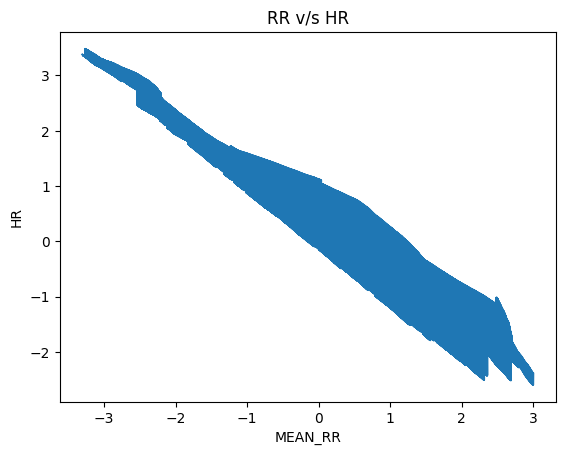

In [33]:
sns.lineplot(data=df_z_clean,x="MEAN_RR",y="HR")
plt.title("RR v/s HR")
plt.xlabel("MEAN_RR")
plt.ylabel("HR")
plt.show()

Confirms the inverse propotionality b/w RR intervals and Heart rate

/tmp/ipython-input-1890249565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_z_clean["LF_HF"]=df_z_clean["LF"]/df_z_clean["HF"]


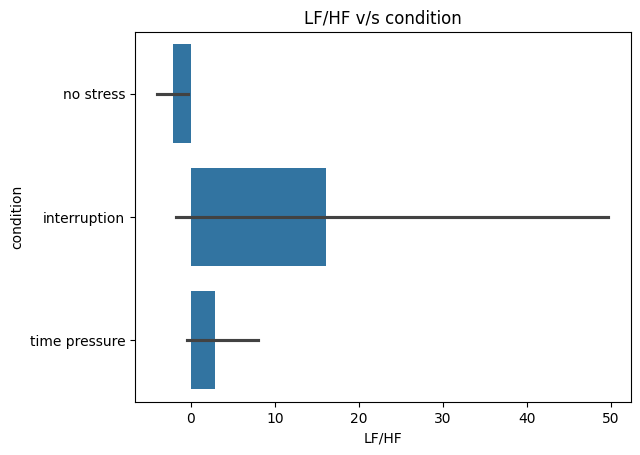

In [32]:
df_z_clean["LF_HF"]=df_z_clean["LF"]/df_z_clean["HF"]
sns.barplot(data=df_z_clean,x="LF_HF",y="condition")
plt.title("LF/HF v/s condition")
plt.xlabel("LF/HF")
plt.ylabel("condition")
plt.show()


In general LF/HF reflects both sympathetic (Fight and flight i.e., HR naturally high) and parasympathetic (Rest and digest i.e., HR naturally low) so looking at the following we can see in less stress conditions our LF/HF ratio is small indicating a parasympathetic response while interruption indicates sympathetic response what we dont expect from time pressure is that it also shows a more parasympathetic response when compared to interruption

One explaination can be since interruptions are sudden the stress felt is more while in time pressure we eventually adapt due to which our sympathetic response sometimes loosens

Since RR intervals are time b/w two R peaks in a signal and higuci (HFD) decides how the signal behaves in different time scales after zooming in or zooming out so since both are time based hence we will see if there is any relation b/w both

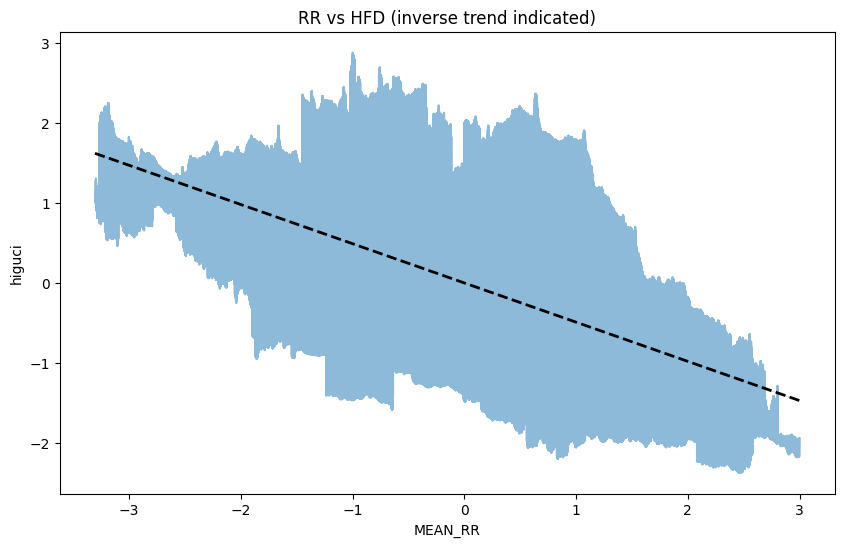

In [41]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_z_clean, x="MEAN_RR", y="higuci", alpha=0.5)
sns.regplot(data=df_z_clean, x="MEAN_RR", y="higuci",
            scatter=False, color="k", line_kws={'lw':2, 'ls':'--'})
plt.title("RR vs HFD (inverse trend indicated)")
plt.xlabel("MEAN_RR")
plt.ylabel("higuci")
plt.show()


Overall its an inversely proportinal relationship on an average while some values may differ due to the vast amount of data